In this notebook I will be setting up functions which will access both our database for previous price entry points and validation of trades, as well as current price data to quantify our gains and losses.
I will do this by importing our model peformance database columns of close price as entry point, and correct trade as a validator. After importing these columns, we will access the current daily price of Bitcoin to compare against our entry price. If the prediction was correct, we will take the positive absolute value of the percentage difference between entry price and current price; otherwise, the negative absolute percentage value will be taken. After this our stake amount will be modified by this percentage modifier to give our new stake amount, stake amount will be tracked progressively through time and will be implemented into our model_performance script.

In [2]:
import pandas as pd
import numpy as np
from binance import Client
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt

In [4]:
# we will slightly modify a function used in previous sections to access our desired columns only


def get_trade_info(limit=1):
    '''
    This will retrieve our most recent prediction
    '''
    
    conn = None
    try:
        conn = sqlite3.connect('bitcoin_model.db')
        print('Connected Successfully!')
    
    except Error as e:
        print(e)
        
    if limit==None:
        query = """
            SELECT Date, Close as Entry, Correct_Pred as Win
            FROM performance ORDER BY Date DESC
            """
    else:
        query = f"""
            SELECT Date, Close as Entry, Correct_Pred as Win
            FROM performance ORDER BY Date DESC LIMIT {limit}
            """
    
    data = pd.read_sql(query, conn, parse_dates=['Date'])        # adding in the query, connection, and parsing date column as its correct format
    data.set_index('Date', inplace=True)                         # setting the index of the resulting dataframe to the date column
    conn.close()                                                 # closiung connection to database
    
    return data

In [5]:
get_trade_info(limit=None)

Connected Successfully!


,Entry,Win
Date,,
2021-12-07,50588.95,1
2021-12-06,50441.92,1
2021-12-05,49396.33,1


In [6]:
get_trade_info()

Connected Successfully!


,Entry,Win
Date,,
2021-12-07,50588.95,1


In [12]:
# we will slightly modify our data gathering function from our predictor script

def get_price():
    
    '''
    This function will execute API call to Binance to retrieve data.
    We will export the results of this data into the appropriately named dataframe for further feature engineering.
    '''
    
    client = Client()
    # establishing our blank client
    
    candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY, limit=1)
    # we only need to request the most recent entry
    
    data = pd.DataFrame(candles, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base volume', 'Taker buy quote volume', 'Ignore'])
    # these column labels are as labelled on the Binance API documentation
    
    price = data[['Date', 'Close']]
    # taking only the desired columns
    
    price['Date'] = price['Date'].apply(lambda x: pd.to_datetime(x, unit='ms'))
    # setting date to proper format
    
    price.set_index('Date', inplace=True)
    #setting our index
    
    
    return price

In [20]:
get_price().dtypes

<ipython-input-12-2acfdaa6db6b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Date'] = price['Date'].apply(lambda x: pd.to_datetime(x, unit='ms'))


Close    object
dtype: object

In [107]:
# now to create a function that will calcuate our net percentage difference in price change and assign a value against 
# todays price which will be fetched from binance


def get_gains():
    '''
    This function will intake the resulting dataframes from the get_trade_info  and get_price functions and check the result against 
    our entry price. This will then calculate a net percentage change. Using the value in the "win" column,
    we can tell the function to apply a positive or negative change to our stake value. All of this data will then
    be stored to a new database for recall.
    '''
    trades = get_trade_info()
    price = get_price()
    price.Close = price.Close.astype('float')
    stake_in = from_gains()
    
    
    trades['Exit'] = price.Close.values
    net_change = abs(trades.Exit - trades.Entry)
    trades['Pct_Change'] = 0
    trades['Gains(%)'] = 0
    trades['Stake_In'] = stake_in
    trades['Stake_Out'] = 0
    trades['Net_Profits'] = 0
    trades['Profit_YTD'] = 0
    trades['ROI(%)'] = 0
    
    
    pct = net_change / trades.Entry
    trades['Pct_Change'] = pct
    trades['Gains(%)'] = -(trades.Pct_Change) if trades.Win.values == 0 else trades.Pct_Change
    trades['Stake_Out'] = trades.Stake_In + (trades.Stake_In * trades['Gains(%)'])
    trades['Net_Profits'] = trades.Stake_Out - trades.Stake_In
    trades['Profit_YTD'] = trades.Stake_Out - 1000
    trades['ROI(%)'] = trades.Profit_YTD / 1000
    
    
    trades
    
    return trades

In [111]:
get_gains()

Connected Successfully!
Connected Successfully!


<ipython-input-12-2acfdaa6db6b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Date'] = price['Date'].apply(lambda x: pd.to_datetime(x, unit='ms'))


,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD,ROI(%)
Date,,,,,,,,,,
2021-12-07,50588.95,1,50543.82,0.000892,0.000892,1026.487048,1027.402769,0.915721,27.402769,0.027403


In [110]:
gains_db(Y)

Connected Successfully!


In [34]:
X = get_trade_info(limit=None)

X2 = X.tail(2)

Connected Successfully!


In [35]:
X

,Entry,Win
Date,,
2021-12-07,50588.95,1
2021-12-06,50441.92,1
2021-12-05,49396.33,1


In [36]:
X2

,Entry,Win
Date,,
2021-12-06,50441.92,1
2021-12-05,49396.33,1


TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [43]:
X2['Exit'] = 0
for i in range(len(X2.index)):
    X2['Exit'][i] = X['Entry'][i]

<ipython-input-43-5f5fcd83e099>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['Exit'] = 0
<ipython-input-43-5f5fcd83e099>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['Exit'][i] = X['Entry'][i]


In [44]:
X2


,Entry,Win,Exit
Date,,,
2021-12-06,50441.92,1,50588
2021-12-05,49396.33,1,50441


In [55]:
abs(X2.Exit[0] - X2.Entry[0])

146.08000000000175

In [57]:
X2['Pct_Change'] = 0
X2['Gains(%)'] = 0
X2['Stake_In'] = 1000
X2['Stake_Out'] = 0
X2['Net_Profits'] = 0
X2['Profit_YTD'] = 0



<ipython-input-57-51485c69a5c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['Pct_Change'] = 0
<ipython-input-57-51485c69a5c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['Gains(%)'] = 0
<ipython-input-57-51485c69a5c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [58]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD
Date,,,,,,,,,
2021-12-06,50441.92,1,50588,0,0,1000,0,0,0
2021-12-05,49396.33,1,50441,0,0,1000,0,0,0


In [67]:
X2.loc[X2.index[0],'Entry']

50441.92

In [79]:
for j in X2.index:
            net_change = abs(X2.Exit[j] - X2.Entry[j])
            pct = net_change / X2.Entry[j]
            X2.loc[j,'Pct_Change'] = pct
            X2.loc[j, 'Gains(%)'] = -(X2.Pct_Change[j]) if X2.Win[j] == 0 else X2.Pct_Change[j]
            X2.loc[j, 'Stake_Out'] = X2.Stake_In[j] + (X2.Stake_In[j] * X2['Gains(%)'][j])
            X2.loc[j, 'Net_Profits'] = X2.Stake_Out[j] - X2.Stake_In[j]
            X2.loc[j, 'Profit_YTD'] = X2.Stake_Out[j] - 1000

/Users/shmaze/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [80]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD
Date,,,,,,,,,
2021-12-06,50441.92,1,50588,0.002896,0.002896,1000,1002.896004,2.896004,2.896004
2021-12-05,49396.33,1,50441,0.021149,0.021149,1000,1021.148737,21.148737,21.148737


In [81]:
X2.loc[X2.index[0], 'Stake_In'] = X2.loc[X2.index[1], 'Stake_Out']

/Users/shmaze/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [82]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD
Date,,,,,,,,,
2021-12-06,50441.92,1,50588,0.002896,0.002896,1021.148737,1002.896004,2.896004,2.896004
2021-12-05,49396.33,1,50441,0.021149,0.021149,1000.000000,1021.148737,21.148737,21.148737


In [83]:
for j in X2.index:
            net_change = abs(X2.Exit[j] - X2.Entry[j])
            pct = net_change / X2.Entry[j]
            X2.loc[j,'Pct_Change'] = pct
            X2.loc[j, 'Gains(%)'] = -(X2.Pct_Change[j]) if X2.Win[j] == 0 else X2.Pct_Change[j]
            X2.loc[j, 'Stake_Out'] = X2.Stake_In[j] + (X2.Stake_In[j] * X2['Gains(%)'][j])
            X2.loc[j, 'Net_Profits'] = X2.Stake_Out[j] - X2.Stake_In[j]
            X2.loc[j, 'Profit_YTD'] = X2.Stake_Out[j] - 1000

/Users/shmaze/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [84]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD
Date,,,,,,,,,
2021-12-06,50441.92,1,50588,0.002896,0.002896,1021.148737,1024.105988,2.957251,24.105988
2021-12-05,49396.33,1,50441,0.021149,0.021149,1000.000000,1021.148737,21.148737,21.148737


In [85]:
X2['ROI(%)'] = X2.Profit_YTD / 1000

<ipython-input-85-18c1d6fae81e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['ROI(%)'] = X2.Profit_YTD / 1000


In [89]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD,ROI(%)
Date,,,,,,,,,,
2021-12-06,50441.92,1,50588,0.002896,0.002896,1021.148737,1024.105988,2.957251,24.105988,0.024106
2021-12-05,49396.33,1,50441,0.021149,0.021149,1000.000000,1021.148737,21.148737,21.148737,0.021149


In [87]:
# now we need one last function which will write our new data into our last database

def gains_db(gains_df):
    '''
    This function will take in our created gains df and append it to our existing database.
    '''
    
    conn = None
    try:
        conn = sqlite3.connect('bitcoin_model.db')
        print('Connected Successfully!')
    
    except Error as e:
        print(e)
        
    gains_df.to_sql('quantitative_stats', con=conn, if_exists='append')
    
        
    conn.close()
    
    
    
    
    
    
    

In [88]:
gains_db(X2)

Connected Successfully!


In [112]:
# now we need a function to recall the most recent stake out value to be input into our other function to calculate
# our cumulative gains

def get_stake():
    
    conn = None
    try:
        conn = sqlite3.connect('bitcoin_model.db')
        print('Connected Successfully!')
    
    except Error as e:
        print(e)
    
    query = """
            SELECT Stake_Out
            FROM quantitative_stats
            ORDER BY Date DESC LIMIT 1
            """
    
    data = pd.read_sql(query, conn, parse_dates=['Date'])
    
        
    conn.close()
    
    return data.Stake_Out.values[0]

In [113]:
X2

,Entry,Win,Exit,Pct_Change,Gains(%),Stake_In,Stake_Out,Net_Profits,Profit_YTD,ROI(%)
Date,,,,,,,,,,
2021-12-06,50441.92,1,50588,0.002896,0.002896,1021.148737,1024.105988,2.957251,24.105988,0.024106
2021-12-05,49396.33,1,50441,0.021149,0.021149,1000.000000,1021.148737,21.148737,21.148737,0.021149


In [122]:
# a function for retrieving all relevant information for displayiong model quantitative performance over time


def get_quant_data():
    
    conn = None
    try:
        conn = sqlite3.connect('bitcoin_model.db')
        print('Connected Successfully!')
    
    except Error as e:
        print(e)
    
    query = r"""
            SELECT *
            FROM quantitative_stats
            ORDER BY Date
            """
    
    data = pd.read_sql(query, conn, parse_dates=['Date'])
    
    data.set_index('Date', inplace=True)
    data.drop(['Entry', 'Exit', 'Win', 'Pct_Change', 'Stake_In'], axis=1, inplace=True)
    conn.close()
    
    return data

In [123]:
get_quant_data()

Connected Successfully!


,Gains(%),Stake_Out,Net_Profits,Profit_YTD,ROI(%)
Date,,,,,
2021-12-05,0.021149,1021.148737,21.148737,21.148737,0.021149
2021-12-06,0.002896,1024.105988,2.957251,24.105988,0.024106
2021-12-07,0.002325,1026.487048,2.381060,26.487048,0.026487


In [129]:
# now we need a function that will output all of our desired metrics


def quant_charts(quant_data):
    '''
    This function intakes the resulting dataframe of the "get_quant_data" function and outputs graphs and charts showing 
    model performance over time
    '''
   
    fig, (ax1, ax2, ax3)  = plt.subplots(3,1, figsize=(15,9))
    
    ax1.plot(quant_data.index, quant_data['Gains(%)'], color='royalblue', label='Daily Gain(%)', marker='o')
    ax1.plot(quant_data.index, quant_data['ROI(%)'], color='seagreen', label='Model ROI(%)', marker='x')
    ax1.set_xlabel('Date', fontsize=25)
    ax1.set_title('Daily Gains and Model Return on Investment', fontsize=25)
    ax1.set_ylabel('Return', fontsize=20)
    ax1.legend(fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)              
    
    ax2.plot(quant_data.index, quant_data['Net_Profits'], label='Daily', marker='o', color='royalblue')  
    ax2.plot(quant_data.index, quant_data['Profit_YTD'], label='Year-to-Date', marker='x', color='seagreen')
    ax2.set_title('Daily and Year-to-Date Net Profits', fontsize=25)
    ax2.set_ylabel('Profits', fontsize=20)
    ax2.set_xlabel('Date', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=15)
    ax2.legend(fontsize=15)
    
    ax3.plot(quant_data.index, quant_data['Stake_Out'], label='Total Value', color='royalblue', marker='x')
    ax3.set_title('Total Value Over Time', fontsize=25)
    ax3.set_ylabel('Total Value', fontsize=20)
    ax3.set_xlabel('Date', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=15)
    
    fig.tight_layout(pad=3)
    fig.show()
    
 

Connected Successfully!


<ipython-input-129-549453859cbf>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


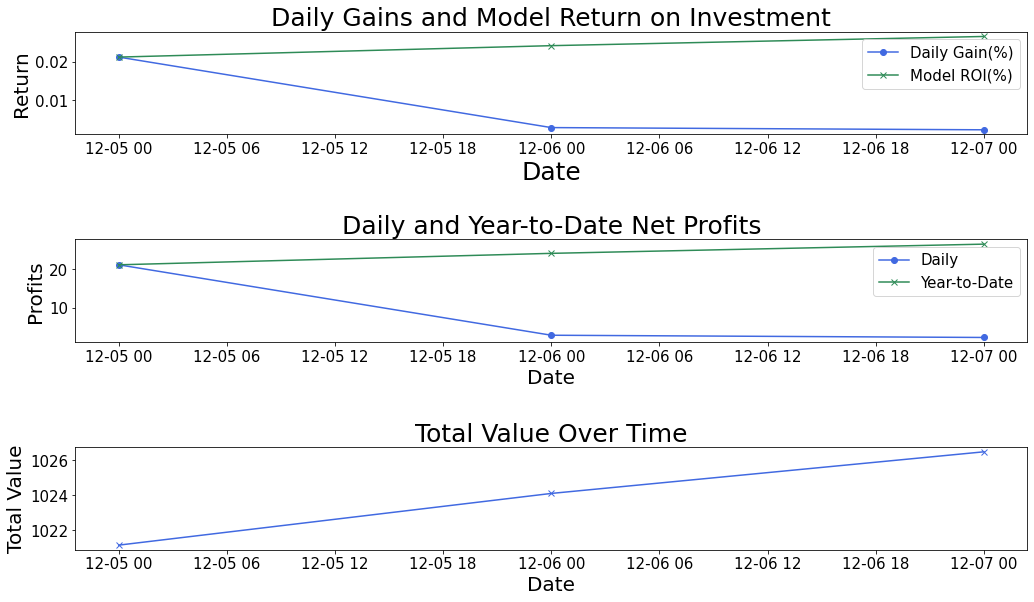

In [130]:
quant_charts(get_quant_data())